In [2]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf

from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("../functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [3]:
modelpath = "../models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec_ERSST = np.arange(1854+3*run+leadtime,2024,)
obsyearvec_HadISST = np.arange(1870+3*run+leadtime,2024,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)
latvec = np.arange(-90+inres/2,90+inres/2,inres)
lonvec = np.arange(0+inres/2,360+inres/2,inres)

weights = np.meshgrid(lon,lat)[1]
latweights = np.sqrt(np.cos(np.deg2rad(weights)))

In [4]:
datafile = "../processed_data/" + filefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

trainvaltest = [trainvariants,valvariants,testvariants]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

nvars = int(len(valvariants)*len(modellist))
nvariant = len(testvariants)
nvars_test = int(len(testvariants))*len(modellist)
nmodels = len(modellist)
ntimesteps = int(len(outputtest)/(nvariant*nmodels))
n1model = ntimesteps*nvariant

mask = np.copy(outputtest)
mask[mask==0] = np.nan
landmask = ~np.isnan(np.mean(mask,axis=0))
latweights[~landmask] = 0

conversion done


In [5]:
inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_obs(experiment_dict,"ERSST")
inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,run)

inputobs_HadISST,outputobs_HadISST = preprocessing.make_inputoutput_obs(experiment_dict,"HadISST")
inputobs_HadISST,outputobs_HadISST = preprocessing.concatobs(inputobs_HadISST,outputobs_HadISST,outputstd,run)

In [6]:
def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def model_member_corr(pattern,outputtest,y_pred_test,nmodels,nvariant,landmask):
    
    modelpearsons = np.empty((nmodels,nvariant))
    modelps = np.empty((nmodels,nvariant))
    
    #modelpearsonsall = np.empty((nmodels))

    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,landmask)
    
    return modelpearsons

def weightedMSE(y_pred,y_true,weights):
    err = ((y_pred-y_true)*weights)
    sqerr = err**2
    mse = np.mean(sqerr)
    return mse

In [7]:
domainMSE = []
SCMSE = []

for random_seed in seedlist:

    fileout = filename + "_seed=" + str(random_seed) +".h5"

    tf.random.set_seed(random_seed)
    np.random.seed(random_seed) 
    
    full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                    experiment_dict, random_seed)  
    
    full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                        loss=tf.keras.losses.MeanSquaredError(), 
                      )

    full_model.load_weights(fileout)
    
    full_model.trainable = False # freeze BN

    y_pred_val = full_model.predict(inputval) 
    
    bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   
    SCtimeseries_true = allthelinalg.index_timeseries(outputval,bestpattern,landmask)
    SCtimeseries_pred = allthelinalg.index_timeseries(y_pred_val,bestpattern,landmask)
    SCtimeseries_err = np.mean((SCtimeseries_true-SCtimeseries_pred)**2)
    
    mse = weightedMSE(y_pred_val,outputval,latweights)
    domainMSE.append(mse)
    SCMSE.append(mse)

domainMSE = np.asarray(domainMSE)
bestseed = np.argmin(domainMSE)


336/336 [==============================] - 1s 4ms/step


In [8]:
imp.reload(analysisplots)
random_seed = seedlist[bestseed]

fileout = filename + "_seed=" + str(random_seed) +".h5"

tf.random.set_seed(random_seed)
np.random.seed(random_seed) 

full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                experiment_dict, random_seed)  

full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                    loss=tf.keras.losses.MeanSquaredError(), 
                  )

full_model.load_weights(fileout)

full_model.trainable = False # freeze BN

y_pred_test = full_model.predict(inputtest)
y_pred_val = full_model.predict(inputval) 
y_pred_obs_ERSST = full_model.predict(inputobs_ERSST)

bestpattern = allthelinalg.calculate_SC_weighted(y_pred_val,outputval,landmask,latweights)   

5/5 [==============================] - 0s 4ms/step


In [9]:
imp.reload(preprocessing)

tasdomain = [-80,80,0,360]

obs_CRUT = preprocessing.makeoutputonly_obs(experiment_dict,"HadCRUT",tasdomain)

biglat = obs_CRUT.lat
biglon = obs_CRUT.lon
obstastime = obs_CRUT.year
obs_CRUT = np.asarray(obs_CRUT)

obs_ERA = preprocessing.makeoutputonly_obs(experiment_dict,"ERA5",tasdomain)
obsERAtime = obs_ERA.year
obs_ERA = np.asarray(obs_ERA)

/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/data/HadCRUT.5.0.2.0.analysis.anomalies.ensemble_mean.nc
/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/data/ERA5_t2m_monthly_1940-2023_2x2.nc


In [10]:
def latweighting(mat,weights):

    matweighted = np.sum(mat*weights[np.newaxis],axis=(1,2))/np.sum(weights)
    matweighted = matweighted/np.nanstd(matweighted)

    return matweighted


In [11]:
_,weights = np.meshgrid(biglon,biglat)
weights = np.cos(np.deg2rad(weights))

obs_CRUT_globmean = latweighting(obs_CRUT,weights)
obs_ERA_globmean = latweighting(obs_ERA,weights)

_,lilweights = np.meshgrid(lon,lat)
lilweights = np.cos(np.deg2rad(lilweights))

obsERSST_predmean = latweighting(y_pred_obs_ERSST,lilweights)
obsERSST_truemean = latweighting(outputobs_ERSST,lilweights)


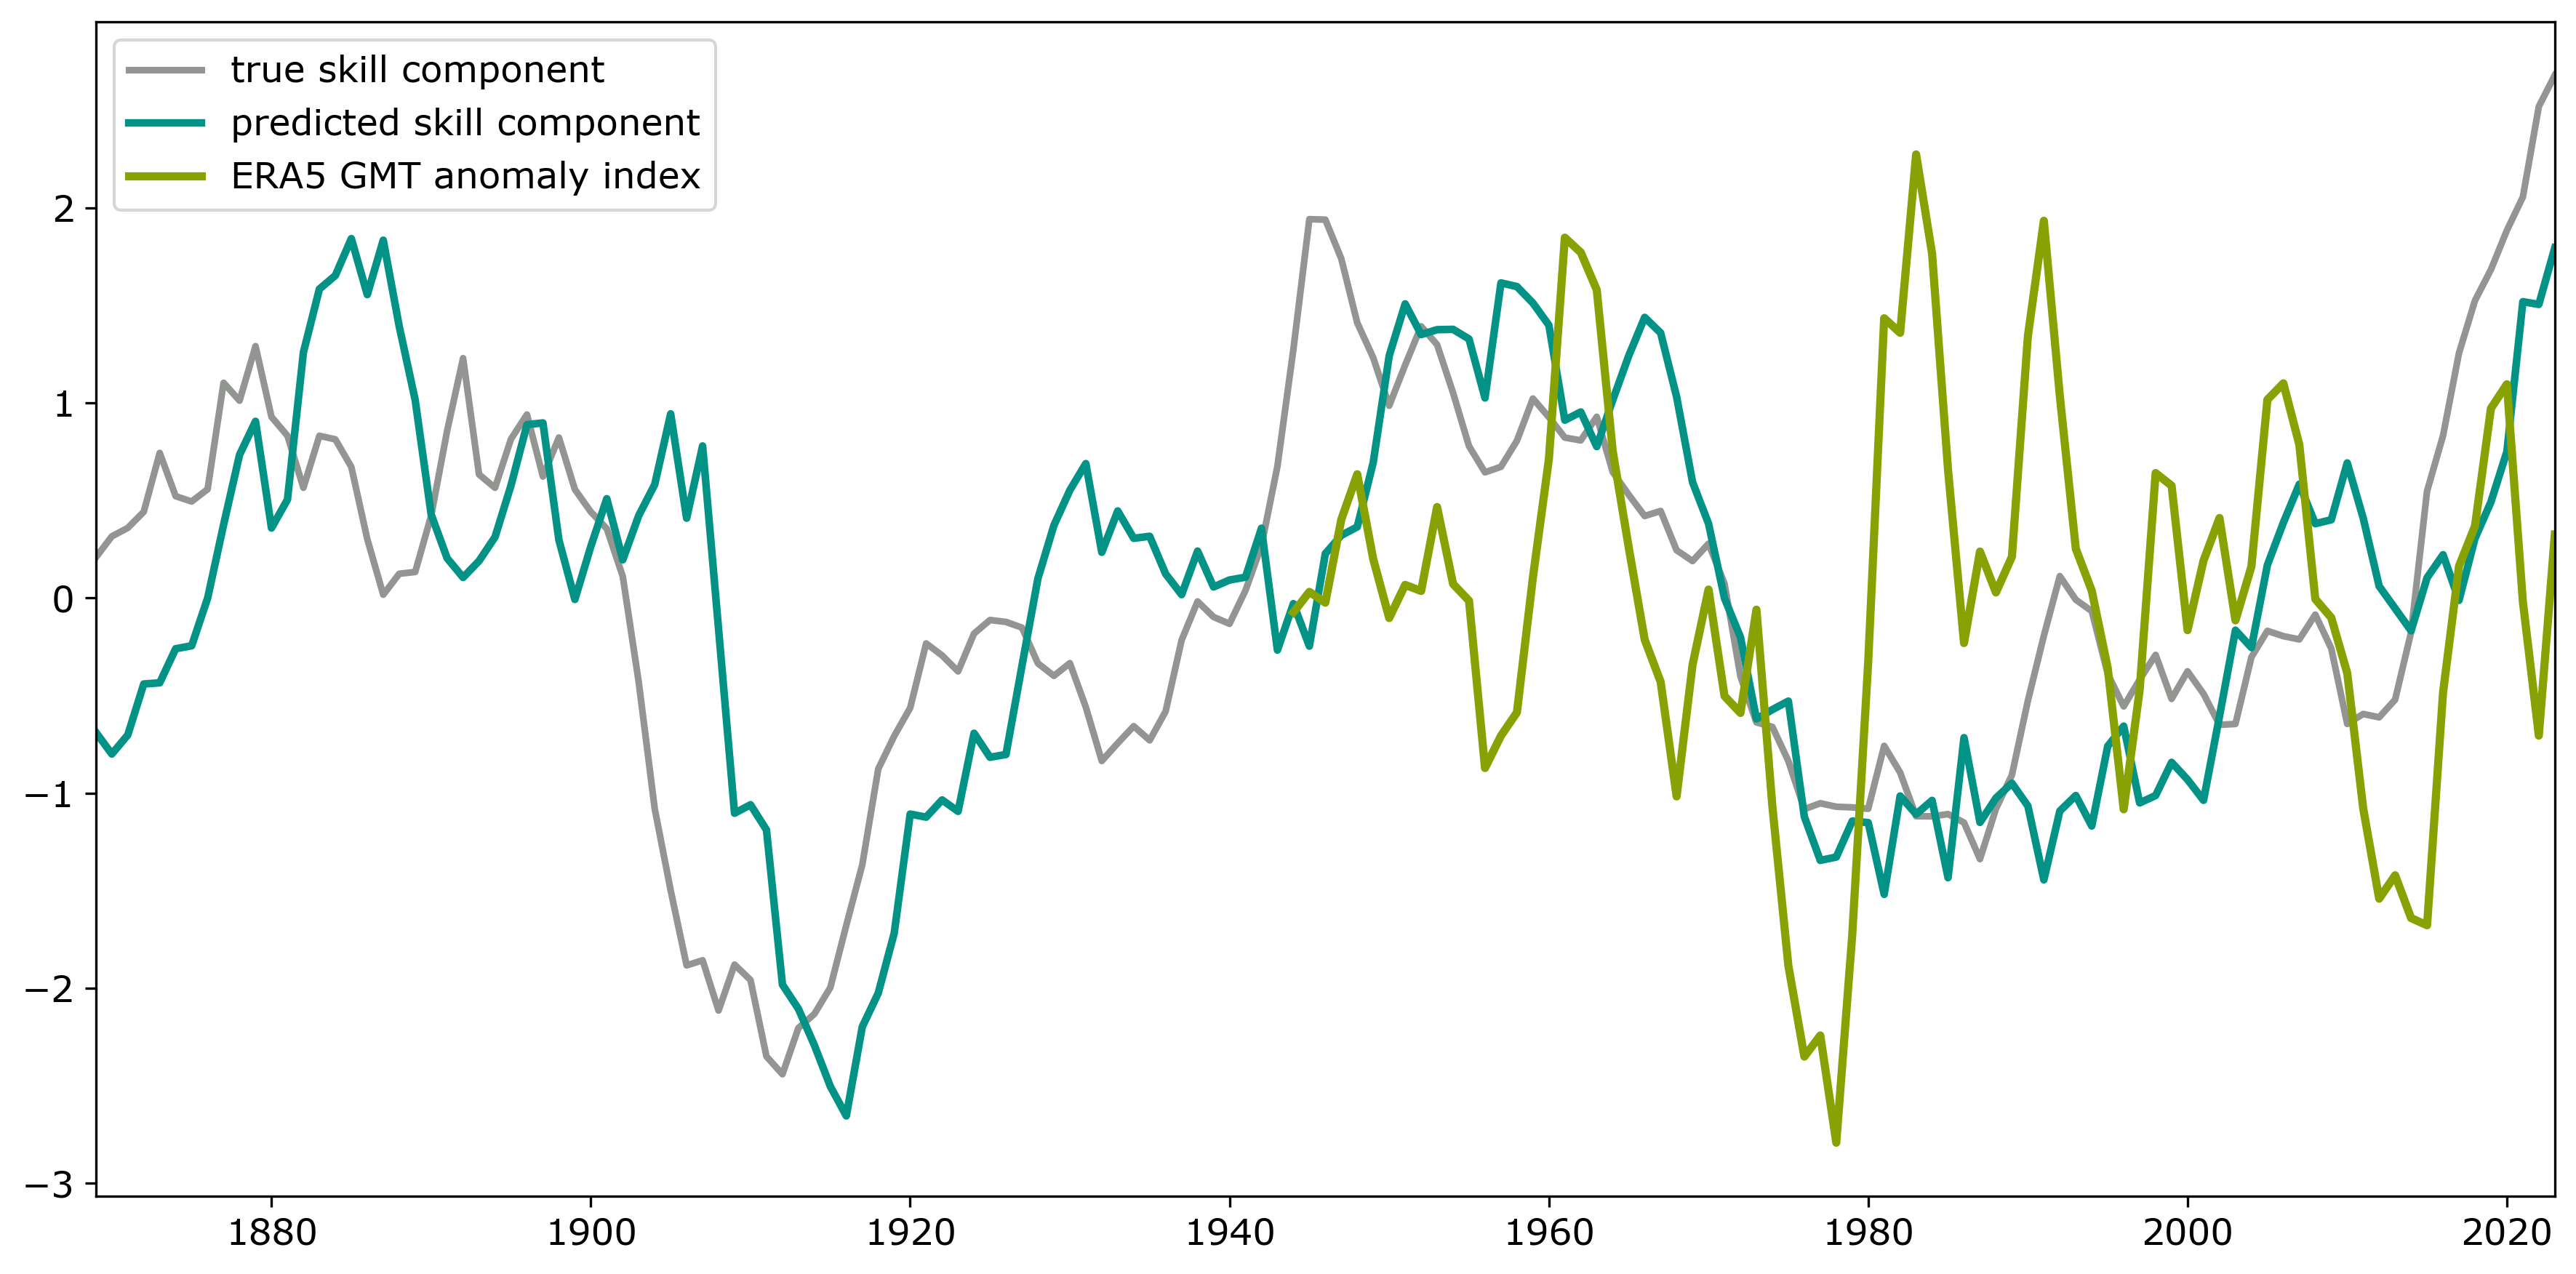

In [20]:
obsERSST_indexpred = allthelinalg.index_timeseries(y_pred_obs_ERSST,bestpattern,landmask)
obsERSST_indextrue = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)

plt.figure(figsize=(12,6))
plt.plot(obsyearvec_ERSST,obsERSST_indextrue,color='xkcd:grey',linewidth=2.2,label='true skill component')
plt.plot(obsyearvec_ERSST,obsERSST_indexpred,color='xkcd:teal',linewidth=2.5,label='predicted skill component')
# plt.plot(obstastime,obs_CRUT_globmean,color='xkcd:vermillion')
plt.plot(obsERAtime,obs_ERA_globmean,color='xkcd:vomit green',linewidth=2.7,label='ERA5 GMT anomaly index')
plt.legend()

plt.xlim(obsyearvec_ERSST[0],obsyearvec_ERSST[-1])

plt.tight_layout()
plt.savefig("../figures/GMTcomparison.png",dpi=200)
